### Cargamos las bibliotecas necesarias. Probamos sin batch normalization

In [1]:
import os
import random
import numpy as np
from itertools import combinations
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, Accuracy


# Importamos algunas dependencias fundamentales de la API de tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Lambda, AveragePooling2D, BatchNormalization, Activation, concatenate


from tensorflow.keras.preprocessing import image
from keras import backend


2025-01-19 22:46:17.542668: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Creamos un posible dataset a partir de los recortes de las caras de las imágenes de entrenamiento del dataset VGG FACE 2

#### Definimos tamaño del lote y las épocas de entrenamiento

In [2]:
tamano_lote = 32
epocas = 400

##### Definimos rutas a las imágenes

In [3]:
ruta_actual=os.getcwd()
ruta_imagenes_entrenamiento = os.path.join(ruta_actual,"recortes_224","entrenamiento")
ruta_imagenes_validacion = os.path.join(ruta_actual,"recortes_224","test")

#### Creamos una función que genera un batch distinto para cada clase de personas existente.

In [4]:
def generacion_batch_parejas(ruta_carpeta_persona,ruta_todas_personas,tamano_lote=32):
    numero_personas_dataset = len(os.listdir(ruta_todas_personas))
    contador = 0
    parejas = []
    imagenes_persona = os.listdir(ruta_carpeta_persona)
    numero_imagenes_persona = len(imagenes_persona)
    
    # No hace falta baraja el dataset de las imágenes de la persona
    #random.shuffle(imagenes_persona)

    #Generamos un número natural aleatorio entre 0 y tamano_lote el cual indica los casos positivos
    numero_casos_positivos = random.randint(0, tamano_lote)
    numero_casos_negativos = tamano_lote-numero_casos_positivos

    #Vamos a tomar el mismo número de casos positivos y negativos en el lote de imágenes
    #numero_casos_positivos = tamano_lote//2
    #numero_casos_negativos = tamano_lote-numero_casos_positivos
    
    #Generamos parejas de imágenes de la misma persona (las imágenes tienen que ser aleatorias porque hemos barajado las mismas)

    for i in range(numero_casos_positivos):
        #Generamos dos números aleatorios entre 0 y el número de fotos de la persona-1 (De esta manera no hace falta barajar el dataset)
        numero_1 = random.randint(0, numero_imagenes_persona-1)
        numero_2 = random.randint(0, numero_imagenes_persona-1)
        
        parejas.append([os.path.join(ruta_carpeta_persona,imagenes_persona[numero_1]),os.path.join(ruta_carpeta_persona,imagenes_persona[numero_2]),1.0])

    
    nombre_carpeta_actual = os.path.basename(ruta_carpeta_persona)
    
    etiquetas_personas = os.listdir(ruta_todas_personas)
    etiquetas_personas.remove(nombre_carpeta_actual)

    ###Nuevo #Calculamos tamano números naturales aleatorios en el rango 0 a numero_personas_entrenamiento-1 como tamano_lote - numero_casos_positivos
    lista_numeros_aleatorios =  [random.randint(0, numero_personas_dataset-2) for _ in range(numero_casos_negativos)]

    #print(lista_numeros_aleatorios)
    #print(len(etiquetas_personas))
    for numero in lista_numeros_aleatorios:

        ruta_persona_aleatoria = os.path.join(ruta_todas_personas,etiquetas_personas[numero])
        lista_imagenes_persona_aleatoria = os.listdir(ruta_persona_aleatoria)
        numero_imagenes_persona_aleatoria = len(lista_imagenes_persona_aleatoria)

        #seleccionamos un número aleatorio para elegir la imagen de la persona negativa y otro número aleatorio para elegir la imagen positiva
        numero_imagen_positiva = random.randint(0, numero_imagenes_persona-1)
        numero_imagen_negativa = random.randint(0, numero_imagenes_persona_aleatoria-1)

        #Añadimos la pareja adecuada
        parejas.append([os.path.join(ruta_carpeta_persona,imagenes_persona[numero_imagen_positiva]),
        os.path.join(ruta_todas_personas,etiquetas_personas[numero],lista_imagenes_persona_aleatoria[numero_imagen_negativa]),0.0])

    #Barajamos las parejas
    random.shuffle(parejas)

    #Transformamos la lista en un array de numpy
    parejas = np.array(parejas)
    #Transformamos las lista con los elementos a un dataset válido usando la api de tensorflow
    img1 = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(parejas[:,0]))
    img2 = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(parejas[:,1]))
    etiqueta = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(parejas[:,2],dtype=tf.float32)) 
    
    dataset = tf.data.Dataset.zip((img1, img2, etiqueta))
    
    return dataset

### Creamos una función para generar un dataset completo que se utilizaría en una única época(se itera si se quiere entrenar más épocas)

In [5]:
def generacion_dataset(ruta_dataset,tamano_lote = 32):
    booleano = True
    lista_carpetas_personas = os.listdir(ruta_dataset)
    
    for carpeta_persona in lista_carpetas_personas:
        if booleano == True:
            dataset = generacion_batch_parejas(os.path.join(ruta_dataset,carpeta_persona),ruta_dataset,tamano_lote)
            booleano = False
        else:
            dataset_inicial = generacion_batch_parejas(os.path.join(ruta_dataset,carpeta_persona),ruta_dataset,tamano_lote)
            dataset = dataset.concatenate(dataset_inicial)

    return dataset

####  Creamos una función para preprocesar las imágenes y las reescalamos para que se adapten a la arquitectura

In [6]:
def preprocesamiento(ruta_imagen):    
    # Leemos la imagen desde su ruta (en formato de bytes)
    byte_img = tf.io.read_file(ruta_imagen)
    # Decodificamos la imagen
    imagen = tf.io.decode_jpeg(byte_img)

    # NO hace falta hacer el resize de la imagen
    #imagen = tf.image.resize(imagen, (105,105))

    # Convertimos la imagen a tipo float32
    imagen = tf.cast(imagen, tf.float32)
    
    # Reescalamos el valor de los píxeles para que esté entre 0 y 1 (Esta normalización es útil para acelerar el entrenamiento) 
    imagen = imagen / 255.0
    
    # Devolvemos la imagen 
    return imagen

#### Creamos una función para procesar las imágenes del dataset de tensorflow mediante el método map

In [7]:
def preprocesamiento_elemento_dataset(imagen1, imagen2, etiqueta):
    return(preprocesamiento(imagen1), preprocesamiento(imagen2), etiqueta)

#### Modificamos los datasets de entrenamiento y test usando el método map, barajando, creando los batches o usando otras opciones que nos puedan parecer adecuadas. 
#### Para simplificar las cosas definimos una función que crea un dataset para ser usado en una época

In [8]:
def crear_dataset(ruta, tamano_lote = 32):
    dataset = generacion_dataset(ruta,tamano_lote)
    dataset = dataset.map(preprocesamiento_elemento_dataset)

    #Quité esta línea (me parece que puede estar dando problemas)
    #dataset = dataset.cache()
    
    dataset = dataset.batch(tamano_lote)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

### Definimos la arquitectura de la red siamesa

##### En primer lugar definimos la parte del embedding

In [9]:

#Primero definimos el módulo de inception adaptado (En ocasiones en vez de usar maxPooling 3x3 con stride de 2, usaremos L2 pooling)

def l2_pooling(x):
    # Calculamos el cuadrado de los elementos del tensor
    tensor_cuadrado = tf.square(x)
    # Aplicamos avg_pool2d con kernel size de 3x3, stride de 1 y padding 'SAME'
    l2_pool = tf.nn.avg_pool2d(tensor_cuadrado, ksize=3, strides=1, padding="SAME")
    norm = tf.sqrt(l2_pool + 1e-8) #En principio no parece necesario sumar esta pequeña cantidad
    return norm


# Capa de Normalización L2
class L2(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(L2, self).__init__(**kwargs)
 
    # perform the operation
    def call(self, inputs):
        # computamos los cuadrados
        valores = inputs**2.0
        suma = backend.sum(valores)
        norma = backend.sqrt(suma)
        norma = backend.maximum(norma, 1.0e-8)
        normalizacion = inputs / norma
        return normalizacion
 
    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        return input_shape


def modulo_inception_tipo1(volumen_entrada,filtros_1x1, filtros_3x3_reduccion, filtros_3x3, filtros_5x5_reduccion, filtros_5x5, filtros_pool_l2,max_l2,nombre=None):
    #Calculamos la convolucion 1x1
    conv_1x1 = Conv2D(filters = filtros_1x1, kernel_size=(1, 1), padding='same', activation='relu')(volumen_entrada)

    #Calculamos la convolucion 3x3
    conv_3x3 = Conv2D(filters = filtros_3x3_reduccion, kernel_size = (1, 1),  padding='same', activation='relu')(volumen_entrada)
    conv_3x3 = Conv2D(filters = filtros_3x3, kernel_size = (3, 3), padding='same', activation='relu')(conv_3x3)

    #Calculamos la convolucion 5x5
    conv_5x5 = Conv2D(filters = filtros_5x5_reduccion, kernel_size = (1, 1), padding='same', activation='relu')(volumen_entrada)
    conv_5x5 = Conv2D(filters = filtros_5x5, kernel_size = (5, 5), padding='same', activation='relu')(conv_5x5)

    #Calculamos maxPooling 3x3 con stride de 1 o L2 pooling 3x3 con stride de 1 
    if max_l2=="max":
        #Calculamos maxPooling 3x3 con stride de 1
        max_pool = MaxPooling2D(pool_size = (3, 3), strides=(1, 1), padding='same')(volumen_entrada)
        max_pool = Conv2D(filters = filtros_pool_l2, kernel_size = (1, 1), padding='same', activation='relu')(max_pool)

        #Concatenamos todos los tensores
        salida = concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool], axis=3,name=nombre)
        #Devolvemos la concatenación de los tensores anteriores
        return salida

    else:
        #En este caso calculamos L2 pooling
        #EScribir el código directamente falla. Las dos líneas siguientes fallarían
                #tensor_cuadrado = tf.square(volumen_entrada)
                #l2_pool =  tf.nn.avg_pool2d(tensor_cuadrado,ksize = 3, strides=1, padding="SAME")
        l2_pool = Lambda(l2_pooling)(volumen_entrada)
        l2_pool = Conv2D(filters = filtros_pool_l2, kernel_size = (1, 1), padding='same', activation='relu')(l2_pool)
        #Concatenamos todos los tensores
        salida = concatenate([conv_1x1, conv_3x3, conv_5x5, l2_pool], axis=3,name=nombre)
        #Devolvemos la concatenación de los tensores anteriores
        return salida


def modulo_inception_tipo2(volumen_entrada,filtros_3x3_reduccion, filtros_3x3, filtros_5x5_reduccion, filtros_5x5, filtros_pool_l2,nombre=None):
    #Calculamos la convolucion 3x3
    conv_3x3 = Conv2D(filters = filtros_3x3_reduccion, kernel_size = (1, 1),  padding='same', activation='relu')(volumen_entrada)
    #En este caso el stride es de 2
    conv_3x3 = Conv2D(filters = filtros_3x3, kernel_size = (3, 3),strides=(2,2), padding='same', activation='relu')(conv_3x3)

    #Calculamos la convolucion 5x5
    conv_5x5 = Conv2D(filters = filtros_5x5_reduccion, kernel_size = (1, 1), padding='same', activation='relu')(volumen_entrada)
    #En este caso el stride es de 2
    conv_5x5 = Conv2D(filters = filtros_5x5, kernel_size = (5, 5),strides=(2,2), padding='same', activation='relu')(conv_5x5)

    #Calculamos maxPooling 3x3 con stride de 2 
        
    max_pool = MaxPooling2D(pool_size = (3, 3), strides=(2, 2), padding='same', dtype='float64')(volumen_entrada)
    max_pool = Conv2D(filters = filtros_pool_l2, kernel_size = (1, 1), padding='same', activation='relu')(max_pool)

    #Concatenamos todos los tensores
    salida = concatenate([conv_3x3, conv_5x5, max_pool], axis=3,name=nombre)
    #Devolvemos la concatenación de los tensores anteriores
    return salida


    
#Definimos una función para la arquitectura NN2 (basada en la idea de GoogleNet) del paper de FaceNet (Es una red moderadamente grande)

def construccion_embedding(tamano_entrada=(224,224,3), dimension_embedding = 128):
    tensor_entrada = Input(shape=tamano_entrada)

    #Definimos la convolucion inicial con 64 núcleos de 7x7 y stride de 2
    x = Conv2D(filters=64,kernel_size=(7,7),strides=(2,2), padding = 'same', activation='relu', name='conv1_7x7_s2')(tensor_entrada)
    #Calculamos MaxPooling 3x3 con stride de 2
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1_3x3_s2')(x)

    #Quitamos el Batch Normalization de la red original ya que ocasiona problemas durante la inferencia
    #x = BatchNormalization()(x)

    #Definimos una capa parecida al módulo de inception pero solo para filtros 3x3
    x = Conv2D(filters = 64, kernel_size = (1, 1), padding='same', activation='relu', name='conv2_3x3_reduce')(x)
    x = Conv2D(filters = 192, kernel_size = (3, 3), padding='same', activation='relu', name='conv2_3x3')(x)

    #Aplicamos normalización y maxPooling3D con filtros 3x3 y stride de 2 (en este orden)
    #Quitamos el Batch Normalization de la red original ya que ocasiona problemas durante la inferencia
    #x = BatchNormalization()(x)
    
    x = MaxPooling2D(pool_size = (3, 3), strides=(2, 2), padding='same', name='maxpool2_3x3_s2')(x)

    #Definimos los distintos módulos de inception
    #Inception 3a
    x = modulo_inception_tipo1(x,64,96,128,16,32,32,"max","inception3a")
    #Inception 3b
    x = modulo_inception_tipo1(x,64,96,128,32,64,64,"l2","inception3b")
    #Inception 3c
    x = modulo_inception_tipo2(x,128,256,32,64,320,"inception3c")
    #Inception 4a
    x = modulo_inception_tipo1(x,256,96,192,32,64,128,"l2","inception4a")
    #Inception 4b
    x = modulo_inception_tipo1(x,224,112,224,32,64,128,"l2","inception4b")
    #Inception 4c
    x = modulo_inception_tipo1(x,192,128,256,32,64,128,"l2","inception4c")
    #Inception 4d
    x = modulo_inception_tipo1(x,160,144,288,32,64,128,"l2","inception4d")
    #Inception 4e
    x = modulo_inception_tipo2(x,160,256,64,128,640,"inception4e")
    #Inception 5a
    x = modulo_inception_tipo1(x,384,192,384,48,128,128,"l2","inception5a")
    #Inception 5b
    x = modulo_inception_tipo1(x,384,192,384,48,128,128,"max","inception5b")

    #Capa de Average pooling
    x = AveragePooling2D(pool_size = (7,7))(x)
    #Aplanamos
    x = Flatten()(x)
    #Añadimos una capa densa con 128 neuronas
    x = Dense(units=128, activation='relu')(x)
    #Normalizamos la salida de la capa densa para obtener la capa de embedding final
    embedding =  L2()(x)
    
    
    modelo_NN2 = Model(tensor_entrada,embedding,name="NN2")
    return modelo_NN2
    



##### Instanciamos el embedding y mostramos sus parámetros con el método summary de la clase Model

In [10]:
embedding = construccion_embedding()

2025-01-19 22:46:19.819213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-19 22:46:19.894472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-19 22:46:19.894577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-19 22:46:19.895295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [11]:
embedding.summary()

Model: "NN2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_7x7_s2 (Conv2D)          (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 maxpool1_3x3_s2 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv1_7x7_s2[0][0]']           
                                                                                                

#### Construimos la capa de distancia L1

In [12]:
# Creamos una capa personalizada para la distancia L1 de la red siamesa
class L1Dist(Layer):
    
    # Heredamos el método de la clase padre Layer
    def __init__(self, **kwargs):
        super().__init__()
       
    # Definimos lo que ocurre cuando se le pasan datos a la capa personalizada
    def call(self, embedding_imagen1, embedding_imagen2):
        return tf.math.abs(embedding_imagen1 - embedding_imagen2)

#### Definimos el modelo de red siamesa 

In [13]:
def construccion_red_siamesa(): 
    
    # Dimensiones de las imágenes de entrada al modelo
    imagen_entrada_1 = Input(name='input_img', shape=(224,224,3))
    
    imagen_entrada_2 = Input(name='validation_img', shape=(224,224,3))
    
    # Calculamos la distancia "siamesa"
    capa_siamesa = L1Dist()
    capa_siamesa._name = 'distancia'
    distancias = capa_siamesa(embedding(imagen_entrada_1), embedding(imagen_entrada_2))
    
    # Definimos una capa de clasificación en dos clases (son la misma imagen ó son distintas imágenes) 
    clasificador = Dense(1, activation='sigmoid')(distancias)
    
    return Model(inputs=[imagen_entrada_1, imagen_entrada_2], outputs=clasificador, name='red_siamesa')

#### Instanciamos la red siamesa y comprobamos su estructura

In [14]:
red_siamesa = construccion_red_siamesa()

In [15]:
red_siamesa.summary()

Model: "red_siamesa"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 NN2 (Functional)               (None, 128)          7969264     ['input_img[0][0]',              
                                                                  'validation_img[0][0]'

#### Definimos la función de pérdida, el optimizador y un lugar de checkpoint

###### Definimos la función de pérdida adecuada para la función sigmoide

In [16]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

###### Definimos un otimizador, por ejemplo Adam con learning rate 0.0004

In [17]:
optimizador = tf.keras.optimizers.Adam(5e-4) # 0.0005

### Construimos un paso de entrenamiento (sobre un único batch) y definimos las métricas Accuracy, recall y precision.

In [18]:
#Definimos en primer lugar las métricas

# Definimos la métrica Accuracy
accuracy_entrenamiento = Accuracy()
accuracy_test = Accuracy()

# Definimos la métrica de Recall
recall_entrenamiento = Recall()
recall_test = Recall()

# Definimos la métrica de Precision
precision_entrenamiento = Precision()
precision_test = Precision()


@tf.function
def paso_entrenamiento(batch):
    
    # Grabamos todas las operaciones 
    with tf.GradientTape() as tape:     
        # Obtenemos las imágenes del batch
        X = batch[:2]
        # Obtenemos la etiqueta
        y_real = batch[2]
        
        # Calculamos el valor del modelo sobre la entrada X
        y_prediccion = red_siamesa(X, training=True)
        # Calculamos el error
        loss = binary_cross_loss(y_real, y_prediccion)

    lista_predicciones = tf.cast(y_prediccion > 0.5, tf.int32)
    lista_predicciones = tf.squeeze(lista_predicciones)  # Aseguramos que la forma sea (batch_size,)
   
    #Calculamos el accuracy sobre las imágenes del lote
    accuracy_entrenamiento.update_state(y_real, lista_predicciones)
    #accuracy = accuracy_entrenamiento.result().numpy()
    accuracy = accuracy_entrenamiento.result()
    
    #Calculamos el recall sobre las imágenes del lote
    recall_entrenamiento.update_state(y_real, lista_predicciones)
    #recall = recall_entrenamiento.result().numpy()
    recall = recall_entrenamiento.result()
    
    #Calculamos la precision sobre las imágenes del lote
    precision_entrenamiento.update_state(y_real, lista_predicciones)
    #precision = precision_entrenamiento.result().numpy()
    precision = precision_entrenamiento.result()
    
    # Calculamos los gradientes 
    gradientes = tape.gradient(loss, red_siamesa.trainable_variables)
    # Actualizamos los pesos del modelo usando los gradientes y el optimizador Adam que definimos
    optimizador.apply_gradients(zip(gradientes, red_siamesa.trainable_variables))
    
    return loss, accuracy, recall, precision

#### Definimos una función para: 
#### 1) calcular el error cometido en el conjunto de validación 
#### 2) calcular el accuracy sobre el conjunto de validación.
#### 3) calcular el recall sobre el conjunto de validación.
#### 4) calcular la precision sobre el conjunto de validación.

In [19]:
# 1) función para calcular el error cometido sobre un dataset
def metricas(dataset):
    loss_total = 0
    loss_promedio = 0
    accuracy_promedio = 0
    recall_promedio = 0
    precision_promedio =0
    
    numero_lotes = len(dataset)
    for batch in dataset:
        # Obtenemos las imágenes del batch
        X = batch[:2]
        # Obtenemos la etiqueta
        y_real = batch[2]
        # Calculamos el valor del modelo sobre la entrada X
        y_prediccion = red_siamesa(X, training=False)
        # Calculamos el error en el lote
        loss_lote = binary_cross_loss(y_real, y_prediccion)

        #Calculamos el error total (suma de los errores de todos los lotes)
        loss_total = loss_total + loss_lote

        #print(f"El error promedio sobre los lotes en el conjunto de test es {loss_total/numero_lotes}")
    
        lista_predicciones = tf.cast(y_prediccion > 0.5, tf.int32)
        lista_predicciones = tf.squeeze(lista_predicciones)  # Aseguramos que la forma sea (batch_size,)
   
        #Calculamos el accuracy sobre las imágenes del lote
        accuracy_test.update_state(y_real, lista_predicciones)
        #accuracy = accuracy_entrenamiento.result().numpy()
        accuracy_lote = accuracy_test.result().numpy()
        accuracy_promedio = accuracy_promedio + accuracy_lote
        
        #Calculamos el recall sobre las imágenes del lote
        recall_test.update_state(y_real, lista_predicciones)
        #recall = recall_entrenamiento.result().numpy()
        recall_lote = recall_test.result().numpy()
        recall_promedio = recall_promedio + recall_lote
    
        #Calculamos la precision sobre las imágenes del lote
        precision_test.update_state(y_real, lista_predicciones)
        #precision = precision_entrenamiento.result().numpy()
        precision_lote = precision_test.result().numpy()
        precision_promedio = precision_promedio + precision_lote

    loss_promedio = loss_total/numero_lotes
    accuracy_promedio = accuracy_promedio/numero_lotes
    recall_promedio = recall_promedio/numero_lotes
    precision_promedio = precision_promedio/numero_lotes
    
    return loss_promedio, accuracy_promedio, recall_promedio, precision_promedio


In [20]:
'''
directorio_pesos_siamesa = os.path.join(os.getcwd(),"pesos_2_noviembre","pesos_siamesa")
directorio_pesos_embedding = os.path.join(os.getcwd(),"pesos_2_noviembre","pesos_embedding")
contador_epocas = 0

def entrenamiento(numero_epocas,tamano_lote=32,contador_epoca=contador_epocas):
    metricas_entrenamiento_epoca = []
    metricas_validacion_epoca = []
    #Creamos el dataset de validación una única vez
    dataset_validacion = crear_dataset(ruta_imagenes_validacion,tamano_lote = tamano_lote)
    
    # Bucle sobre las épocas
    for epoca in range(1, numero_epocas+1):
        print('\n Epoca {}/{}'.format(epoca, numero_epocas))

        #Aumentamos el contador general de épocas
        contador_epoca = contador_epoca +1
        
        #Creamos el dataset de nuevo
        dataset_entrenamiento = crear_dataset(ruta_imagenes_entrenamiento,tamano_lote = tamano_lote)
        
        progbar = tf.keras.utils.Progbar(len(dataset_entrenamiento))
        
        # Iteramos sobre cada batch del dataset
        for idx, batch in enumerate(dataset_entrenamiento):
            # Ejecutamos un paso del entrenamiento (sobre uno de los batches)
            loss, accuracy, recall, precision = paso_entrenamiento(batch)
            loss_lote = loss.numpy()
            accuracy_lote = accuracy.numpy()
            recall_lote = recall.numpy()
            precision_lote = precision.numpy()
            #print(f"Error en el batch de entrenamiento de la época {loss.numpy()}")
            progbar.update(idx+1,[("loss_lote", loss_lote), ("accuracy_lote",accuracy_lote), ("recall_lote",recall_lote), ("precision_lote",precision_lote)])
            #print(f"Error en el batch de entrenamiento de la época {loss.numpy()}")
            

        #Calculamos el error promedio de los batches sobre el conjunto de entrenamiento usado
        loss_entrenamiento,accuracy_entrenamiento,recall_entrenamiento,precision_entrenamiento = metricas(dataset_entrenamiento)
        
        #Guardamos los datos de las métricas sobre el conjunto de entrenamiento para cada época
        metricas_entrenamiento_epoca.append([loss_entrenamiento,accuracy_entrenamiento,recall_entrenamiento,precision_entrenamiento])

        loss_entrenamiento_redondeado = np.round(loss_entrenamiento, 5)
        accuracy_entrenamiento_redondeado = np.round(accuracy_entrenamiento, 5)
        recall_entrenamiento_redondeado = np.round(recall_entrenamiento, 5)
        precision_entrenamiento_redondeado = np.round(precision_entrenamiento, 5)
        
        print(f"Resultados promedio sobre el conjunto de entrenamiento usado en la época {contador_epoca}")
        print(f"loss_entrenamiento: {loss_entrenamiento_redondeado}, accuracy_entrenamiento: {accuracy_entrenamiento_redondeado}, recall_entrenamiento: {recall_entrenamiento_redondeado}, precision_entrenamiento: {precision_entrenamiento_redondeado}")
        print("")
        #Calculamos el error promedio de los batches del conjunto de validacion
        loss_validacion,accuracy_validacion,recall_validacion,precision_validacion = metricas(dataset_validacion)

        #Guardamos los datos de las métricas sobre el conjunto de validacion para cada época
        metricas_validacion_epoca.append([loss_validacion,accuracy_validacion,recall_validacion,precision_validacion])

        loss_validacion_redondeado = np.round(loss_validacion, 5)
        accuracy_validacion_redondeado = np.round(accuracy_validacion, 5)
        recall_validacion_redondeado = np.round(recall_validacion, 5)
        precision_validacion_redondeado = np.round(precision_validacion, 5)
        
        print(f"Resultados promedio sobre el conjunto de validación la época {contador_epoca}")
        print(f"loss_validacion: {loss_validacion_redondeado}, accuracy_validacion: {accuracy_validacion_redondeado}, recall_validacion: {recall_validacion_redondeado}, precision_validacion: {precision_validacion_redondeado}")
        print("")
        print(f"guardando pesos de la época {contador_epoca} de entrenamiento ....")
        print("")
        
        #Guardamos los pesos
        red_siamesa.save(f'{directorio_pesos_siamesa}/red_siamesa_epoca_{contador_epoca}.h5')
        embedding.save(f'{directorio_pesos_embedding}/embedding_epoca_{contador_epoca}.h5')
        
        
    
    return metricas_entrenamiento_epoca, metricas_validacion_epoca, contador_epoca
'''


'\ndirectorio_pesos_siamesa = os.path.join(os.getcwd(),"pesos_2_noviembre","pesos_siamesa")\ndirectorio_pesos_embedding = os.path.join(os.getcwd(),"pesos_2_noviembre","pesos_embedding")\ncontador_epocas = 0\n\ndef entrenamiento(numero_epocas,tamano_lote=32,contador_epoca=contador_epocas):\n    metricas_entrenamiento_epoca = []\n    metricas_validacion_epoca = []\n    #Creamos el dataset de validación una única vez\n    dataset_validacion = crear_dataset(ruta_imagenes_validacion,tamano_lote = tamano_lote)\n    \n    # Bucle sobre las épocas\n    for epoca in range(1, numero_epocas+1):\n        print(\'\n Epoca {}/{}\'.format(epoca, numero_epocas))\n\n        #Aumentamos el contador general de épocas\n        contador_epoca = contador_epoca +1\n        \n        #Creamos el dataset de nuevo\n        dataset_entrenamiento = crear_dataset(ruta_imagenes_entrenamiento,tamano_lote = tamano_lote)\n        \n        progbar = tf.keras.utils.Progbar(len(dataset_entrenamiento))\n        \n       

### Construimos una función que ejecuta un bucle de entrenamiento para el modelo

In [21]:
directorio_informacion = os.path.join(os.getcwd(),"pesos_siamesa_final_19_enero")
directorio_pesos_siamesa = os.path.join(os.getcwd(),"pesos_siamesa_final_19_enero","pesos_siamesa")
directorio_pesos_embedding = os.path.join(os.getcwd(),"pesos_siamesa_final_19_enero","pesos_embedding")

contador_epocas = 0

def entrenamiento(numero_epocas,tamano_lote=32,contador_epoca=contador_epocas,paciencia_early_stopping=10, epocas_reduccion_lr=6,lr=5e-4):

    #Se cambia el learning_rate del optimizador si es necesario
    optimizador.learning_rate = lr
    
    metricas_entrenamiento_epoca = []
    metricas_validacion_epoca = []

    contador_paciencia = 0
    contador_reduccion_lr = 0
    tasa_aprendizaje = lr
    
    #Creamos el dataset de validación una única vez
    dataset_validacion = crear_dataset(ruta_imagenes_validacion,tamano_lote = tamano_lote)

    #La variable minimo mide el mínimo obtenido para loss de validación.
    minimo = np.infty

    #Creamos un txt para almacenar los datos de entrenamiento
    
    #Creamos un txt con las métricas de entrenamiento
    archivo_entrenamiento = open(os.path.join(directorio_informacion,"entrenamiento.txt"),"w")

    archivo_entrenamiento.write(f"epoca,loss,accuracy,recall,precision,lr \n")
    archivo_entrenamiento.close()
    
    #Creamos un txt con los datos de las métricas de validación
    archivo_validacion = open(os.path.join(directorio_informacion,"validacion.txt"),"w")
    archivo_validacion.write(f"epoca,loss,accuracy,recall,precision,lr \n")
    archivo_validacion.close()
    
    # Bucle sobre las épocas
    for epoca in range(1, numero_epocas+1):
        print('\n Epoca {}/{}'.format(epoca, numero_epocas))

        #Implementamos early stopping si loss_validación no mejora durante 10 épocas consecutivas
        #Calculamos el mínimo de los losses en validación en la lista
        for elemento in metricas_validacion_epoca:
            if minimo > elemento[0]:
                minimo = elemento[0]

        #Aumentamos el contador general de épocas
        contador_epoca = contador_epoca +1
        
        #Creamos el dataset de nuevo
        dataset_entrenamiento = crear_dataset(ruta_imagenes_entrenamiento,tamano_lote = tamano_lote)
        
        progbar = tf.keras.utils.Progbar(len(dataset_entrenamiento))
        
        # Iteramos sobre cada batch del dataset
        for idx, batch in enumerate(dataset_entrenamiento):
            # Ejecutamos un paso del entrenamiento (sobre uno de los batches)
            loss, accuracy, recall, precision = paso_entrenamiento(batch)
            loss_lote = loss.numpy()
            accuracy_lote = accuracy.numpy()
            recall_lote = recall.numpy()
            precision_lote = precision.numpy()
            #print(f"Error en el batch de entrenamiento de la época {loss.numpy()}")
            progbar.update(idx+1,[("loss_lote", loss_lote), ("accuracy_lote",accuracy_lote), ("recall_lote",recall_lote), ("precision_lote",precision_lote)])
            #print(f"Error en el batch de entrenamiento de la época {loss.numpy()}")
            

        #Calculamos el error promedio de los batches sobre el conjunto de entrenamiento usado
        loss_entrenamiento,accuracy_entrenamiento,recall_entrenamiento,precision_entrenamiento = metricas(dataset_entrenamiento)
        
        #Guardamos los datos de las métricas sobre el conjunto de entrenamiento para cada época
        metricas_entrenamiento_epoca.append([loss_entrenamiento,accuracy_entrenamiento,recall_entrenamiento,precision_entrenamiento])

        loss_entrenamiento_redondeado = np.round(loss_entrenamiento, 5)
        accuracy_entrenamiento_redondeado = np.round(accuracy_entrenamiento, 5)
        recall_entrenamiento_redondeado = np.round(recall_entrenamiento, 5)
        precision_entrenamiento_redondeado = np.round(precision_entrenamiento, 5)

        #Guardamos los datos en el txt de entrenamiento
        archivo_entrenamiento = open(os.path.join(directorio_informacion,"entrenamiento.txt"),"a")
        archivo_entrenamiento.write(f"{epoca},{loss_entrenamiento_redondeado},{accuracy_entrenamiento_redondeado},{recall_entrenamiento_redondeado},{precision_entrenamiento_redondeado},{optimizador.learning_rate.numpy():.10f}\n")
        archivo_entrenamiento.close()
        
        print(f"Resultados promedio sobre el conjunto de entrenamiento usado en la época {contador_epoca}")
        print(f"loss_entrenamiento: {loss_entrenamiento_redondeado}, accuracy_entrenamiento: {accuracy_entrenamiento_redondeado}, recall_entrenamiento: {recall_entrenamiento_redondeado}, precision_entrenamiento: {precision_entrenamiento_redondeado}, tasa_aprendizaje: {tasa_aprendizaje}")
        print("")
        #Calculamos el error promedio de los batches del conjunto de validacion
        loss_validacion,accuracy_validacion,recall_validacion,precision_validacion = metricas(dataset_validacion)

        #Guardamos los datos de las métricas sobre el conjunto de validacion para cada época
        metricas_validacion_epoca.append([loss_validacion,accuracy_validacion,recall_validacion,precision_validacion])

        loss_validacion_redondeado = np.round(loss_validacion, 5)
        accuracy_validacion_redondeado = np.round(accuracy_validacion, 5)
        recall_validacion_redondeado = np.round(recall_validacion, 5)
        precision_validacion_redondeado = np.round(precision_validacion, 5)

        #Guardamos los datos en el txt de validacion
        archivo_validacion = open(os.path.join(directorio_informacion,"validacion.txt"),"a")
        archivo_validacion.write(f"{epoca},{loss_validacion_redondeado},{accuracy_validacion_redondeado},{recall_validacion_redondeado},{precision_validacion_redondeado},{optimizador.learning_rate.numpy():.10f}\n")
        archivo_validacion.close()
        
        print(f"Resultados promedio sobre el conjunto de validación la época {contador_epoca}")
        print(f"loss_validacion: {loss_validacion_redondeado}, accuracy_validacion: {accuracy_validacion_redondeado}, recall_validacion: {recall_validacion_redondeado}, precision_validacion: {precision_validacion_redondeado}, tasa_aprendizaje: {tasa_aprendizaje}")
        print("")
        print(f"guardando pesos de la época {contador_epoca} de entrenamiento ....")
        print("")
        
        #Guardamos los pesos
        red_siamesa.save(f'{directorio_pesos_siamesa}/red_siamesa_epoca_{contador_epoca}.h5')
        embedding.save(f'{directorio_pesos_embedding}/embedding_epoca_{contador_epoca}.h5')

        #Comprobamos si loss_validación es o no mayor que el mínimos de los losses de validacion (incrementamos el contador de paciencia o lo reiniciamos)
        if minimo < loss_validacion:
            contador_paciencia = contador_paciencia +1
            contador_reduccion_lr = contador_reduccion_lr +1 
            print("")
            print(f"El loss del modelo en el conjunto de validación no ha mejorado en la época {epoca}. Mejor loss en validacion =  {minimo}")
            print("")
        else:
            contador_paciencia = 0
            contador_reduccion_lr = 0
            print("")
            print(f"El loss en el conjunto de validación ha mejorado en la época {epoca}. Mejor loss en validacion = {loss_validacion}")
            print("")
            
        #Si el contador de paciencia alcanza el valor límite disminuimos el learning rate en un factor de 2 hasta un límite establecido
        if contador_reduccion_lr == epocas_reduccion_lr and tasa_aprendizaje > 1e-8:
            
            #Se establece a cero el contador de la reducción del learning rate
            contador_reduccion_lr = 0
            tasa_aprendizaje = tasa_aprendizaje/2
            
            #Cambiamos el learning rate del optimizador
            optimizador.learning_rate = tasa_aprendizaje 

            print("*******************************************************************************")
            print(f"Reduciendo la tasa de aprendizaje de {2*tasa_aprendizaje} a {optimizador.learning_rate}")
            print("*******************************************************************************")
            
        
        
        #Salimos del bucle de entrenamiento si el contador de paciencia alcanza el límite establecido
        if contador_paciencia == paciencia_early_stopping:
            print(f"Se para el entrenamiento porque el loss en validación no ha mejorado en {paciencia_early_stopping} épocas")
            for indice, elemento in enumerate(metricas_validacion_epoca):
                if minimo == elemento[0]:
                    print(f"El mejor loss en validación fue {minimo} y se alcanzó en la época {indice+1}")

            break #Salimos del bucle de entrenamiento 

    
    return metricas_entrenamiento_epoca, metricas_validacion_epoca, contador_epoca, tasa_aprendizaje



### Entrenamos el modelo 400 épocas con tamaño de lote 32. Nos quedamos con los que consideremos los mejores pesos de la red. El entrenamiento debería para antes de completar las 400 épocas debido al early stopping implementado. La tasa de aprendizaje inicial es 2e⁻4


In [ ]:

tamano_lote = 32
epocas=400

metricas_entrenamiento_epoca, metricas_validacion_epoca, contador,lr_final = entrenamiento(epocas,tamano_lote=tamano_lote,contador_epoca=contador_epocas,
                                                                           paciencia_early_stopping=50, epocas_reduccion_lr=10,lr= 2e-4)




 Epoca 1/400


2025-01-19 22:47:17.138800: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2025-01-19 22:47:18.333264: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-01-19 22:47:18.333286: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-01-19 22:47:18.333373: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-01-19 22:47:20.413316: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-01-19 22:47:20.413343: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged on

8631/8631 [==============================] - 1497s 172ms/step - loss_lote: 0.6926 - accuracy_lote: 0.5095 - recall_lote: 0.1944 - precision_lote: 0.5184
Resultados promedio sobre el conjunto de entrenamiento usado en la época 1
loss_entrenamiento: 0.6929100155830383, accuracy_entrenamiento: 0.5119, recall_entrenamiento: 0.4822, precision_entrenamiento: 0.51321, tasa_aprendizaje: 0.0002

Resultados promedio sobre el conjunto de validación la época 1
loss_validacion: 0.6930199861526489, accuracy_validacion: 0.51209, recall_validacion: 0.48237, precision_validacion: 0.51605, tasa_aprendizaje: 0.0002

guardando pesos de la época 1 de entrenamiento ....


El loss en el conjunto de validación ha mejorado en la época 1. Mejor loss en validacion = 0.6930153369903564


 Epoca 2/400
8631/8631 [==============================] - 1507s 174ms/step - loss_lote: 0.6916 - accuracy_lote: 0.5203 - recall_lote: 0.4764 - precision_lote: 0.5256
Resultados promedio sobre el conjunto de entrenamiento usado en

#### El Jupyter notebook rompió en este punto, pero el entrenamiento finalizó en segundo plano. Los resultados de métricas de entrenamiento y validación en cada época están disponibles en los txt. Los pesos de los modelos para cada época también están almacenados. Se debe decidir en que época el modelo obtiene los mejores resultados. Para ello vamos a graficar los resultados ahora a partir de la información de los txt.

### Analizamos los resultados (loss) sobre el conjunto de entrenamiento y validación. (No pudo ejecutarse porque el notebook se rompió)

epocas = [i+1 for i in range(len(metricas_entrenamiento_epoca))]  # Lista de épocas
loss_entrenamiento_epoca = [metricas_entrenamiento_epoca[i][0].numpy() for i in range(len(metricas_entrenamiento_epoca))] # Ejemplo de accuracies de entrenamiento
loss_validacion_epoca = [metricas_validacion_epoca[i][0].numpy() for i in range(len(metricas_entrenamiento_epoca))]  # Ejemplo de accuracies de validación

#metricas_entrenamiento_epoca

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Graficar accuracy de entrenamiento
plt.plot(epocas, loss_entrenamiento_epoca, label="Entrenamiento", color='blue', marker='o')

# Graficar accuracy de validación
plt.plot(epocas, loss_validacion_epoca, label="Validación", color='red', marker='x')

# Etiquetas y título
plt.title("loss en función de la época")
plt.xlabel("Época")
plt.ylabel("loss")

# Agregar leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

### Analizamos los resultados (accuracy) sobre el conjunto de entrenamiento y validación. (No pudo ejecutarse porque el notebook se rompió)

epocas = [i+1 for i in range(len(metricas_entrenamiento_epoca))]  # Lista de épocas
accuracy_entrenamiento_epoca = [metricas_entrenamiento_epoca[i][1] for i in range(len(metricas_entrenamiento_epoca))] # Ejemplo de accuracies de entrenamiento
accuracy_validacion_epoca = [metricas_validacion_epoca[i][1] for i in range(len(metricas_entrenamiento_epoca))]  # Ejemplo de accuracies de validación

#metricas_entrenamiento_epoca

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Graficar accuracy de entrenamiento
plt.plot(epocas, accuracy_entrenamiento_epoca, label="Entrenamiento", color='blue', marker='o')

# Graficar accuracy de validación
plt.plot(epocas, accuracy_validacion_epoca, label="Validación", color='red', marker='x')

# Etiquetas y título
plt.title("accuracy en función de la época")
plt.xlabel("Época")
plt.ylabel("accuracy")

# Agregar leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

### Analizamos los resultados (recall) sobre el conjunto de entrenamiento y validación. (No pudo ejecutarse porque el notebook se rompió)

epocas = [i+1 for i in range(len(metricas_entrenamiento_epoca))]  # Lista de épocas
recall_entrenamiento_epoca = [metricas_entrenamiento_epoca[i][2] for i in range(len(metricas_entrenamiento_epoca))] # Ejemplo de accuracies de entrenamiento
recall_validacion_epoca = [metricas_validacion_epoca[i][2] for i in range(len(metricas_entrenamiento_epoca))]  # Ejemplo de accuracies de validación

#metricas_entrenamiento_epoca

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Graficar accuracy de entrenamiento
plt.plot(epocas, recall_entrenamiento_epoca, label="Entrenamiento", color='blue', marker='o')

# Graficar accuracy de validación
plt.plot(epocas, recall_validacion_epoca, label="Validación", color='red', marker='x')

# Etiquetas y título
plt.title("recall en función de la época")
plt.xlabel("Época")
plt.ylabel("recall")

# Agregar leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

### Analizamos los resultados (precision) sobre el conjunto de entrenamiento y validación (No pudo ejecutarse porque el notebook se rompió)

epocas = [i+1 for i in range(len(metricas_entrenamiento_epoca))]  # Lista de épocas
precision_entrenamiento_epoca = [metricas_entrenamiento_epoca[i][3] for i in range(len(metricas_entrenamiento_epoca))] # Ejemplo de accuracies de entrenamiento
precision_validacion_epoca = [metricas_validacion_epoca[i][3] for i in range(len(metricas_entrenamiento_epoca))]  # Ejemplo de accuracies de validación

#metricas_entrenamiento_epoca

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Graficar accuracy de entrenamiento
plt.plot(epocas, precision_entrenamiento_epoca, label="Entrenamiento", color='blue', marker='o')

# Graficar accuracy de validación
plt.plot(epocas, precision_validacion_epoca, label="Validación", color='red', marker='x')

# Etiquetas y título
plt.title("precision en función de la época")
plt.xlabel("Época")
plt.ylabel("precision")

# Agregar leyenda
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

## Graficamos los resultados del entrenamiento mediante los datos grabados en los txt (El cuaderno Jupyter se rompió, pero la ejecuación continuó en segundo plano)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

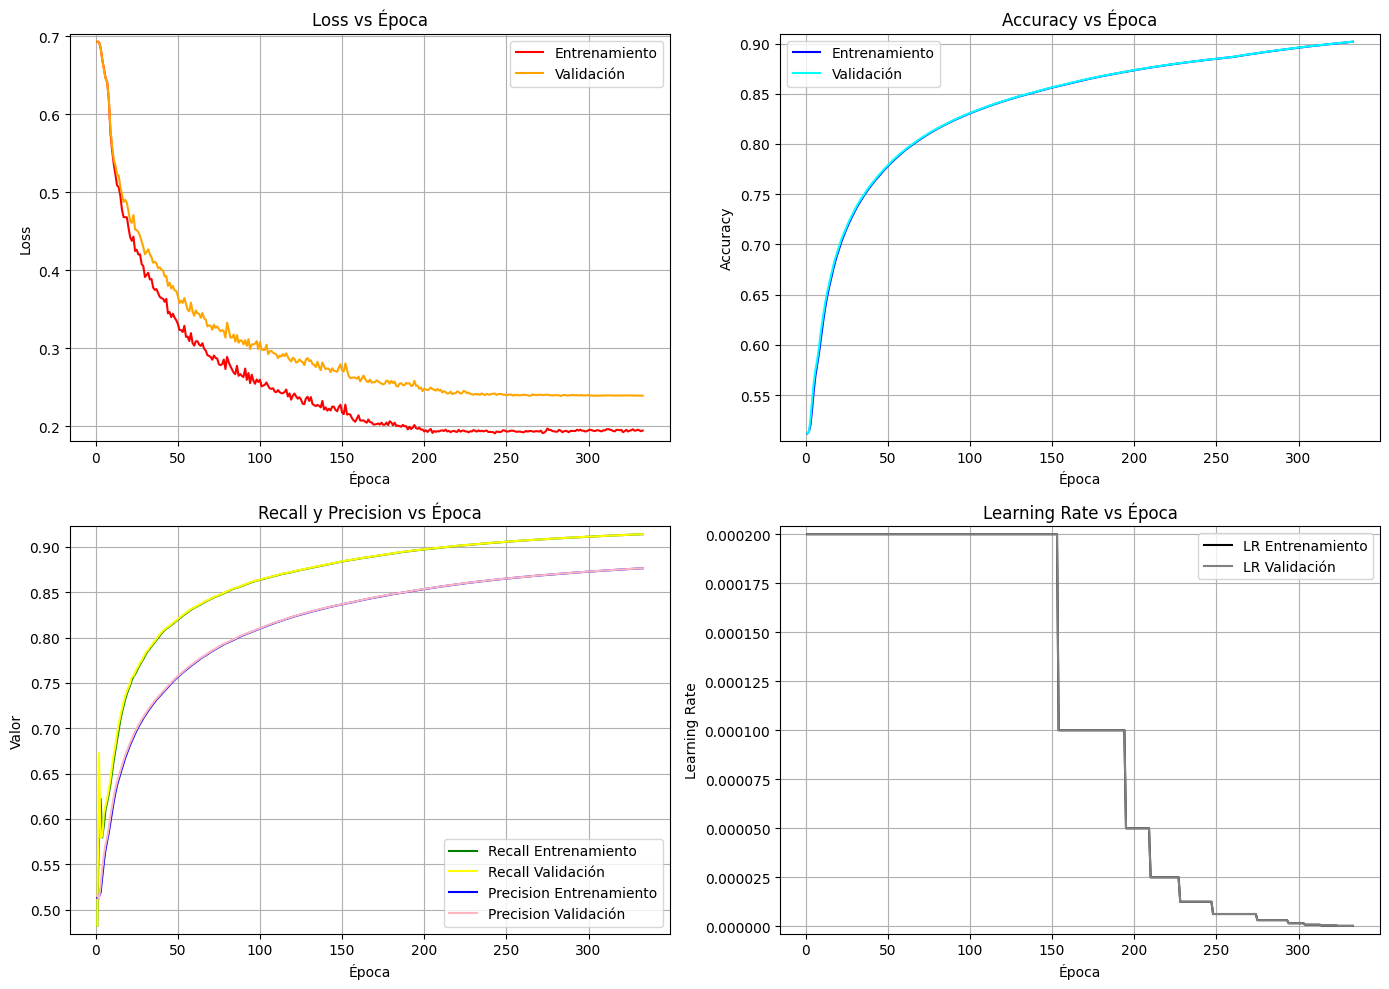

In [2]:
# cargamos los archivos 
df_train = pd.read_csv("pesos_siamesa_final_19_enero/entrenamiento.txt")
df_valid = pd.read_csv("pesos_siamesa_final_19_enero/validacion.txt")

# Limpiamos los nombres de las columnas
df_train.columns = df_train.columns.str.strip()
df_valid.columns = df_valid.columns.str.strip()

# Nos aseguraramos que 'epoca' sea entero
df_train["epoca"] = df_train["epoca"].astype(int)
df_valid["epoca"] = df_valid["epoca"].astype(int)

# Función para ampliar los ejes y ver mejor las diferencias
def auto_ylim(series1, series2, margin=0.02):
    min_val = min(series1.min(), series2.min())
    max_val = max(series1.max(), series2.max())
    delta = (max_val - min_val) * margin
    return (min_val - delta, max_val + delta)

# Graficamos
plt.figure(figsize=(14, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(df_train["epoca"], df_train["loss"], label="Entrenamiento", color='red')
plt.plot(df_valid["epoca"], df_valid["loss"], label="Validación", color='orange')
plt.title("Loss vs Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.ylim(*auto_ylim(df_train["loss"], df_valid["loss"]))
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(df_train["epoca"], df_train["accuracy"], label="Entrenamiento", color='blue')
plt.plot(df_valid["epoca"], df_valid["accuracy"], label="Validación", color='cyan')
plt.title("Accuracy vs Época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.ylim(*auto_ylim(df_train["accuracy"], df_valid["accuracy"]))
plt.legend()
plt.grid(True)

# Recall y Precision
plt.subplot(2, 2, 3)
plt.plot(df_train["epoca"], df_train["recall"], label="Recall Entrenamiento", color='green')
plt.plot(df_valid["epoca"], df_valid["recall"], label="Recall Validación", color='yellow')
plt.plot(df_train["epoca"], df_train["precision"], label="Precision Entrenamiento", color='blue')
plt.plot(df_valid["epoca"], df_valid["precision"], label="Precision Validación", color='lightpink')
plt.title("Recall y Precision vs Época")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.ylim(*auto_ylim(
    pd.concat([df_train["recall"], df_train["precision"]]),
    pd.concat([df_valid["recall"], df_valid["precision"]])
))
plt.legend()
plt.grid(True)

# Learning Rate
plt.subplot(2, 2, 4)
plt.plot(df_train["epoca"], df_train["lr"], label="LR Entrenamiento", color='black')
plt.plot(df_valid["epoca"], df_valid["lr"], label="LR Validación", color='gray')
plt.title("Learning Rate vs Época")
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.ylim(*auto_ylim(df_train["lr"], df_valid["lr"]))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

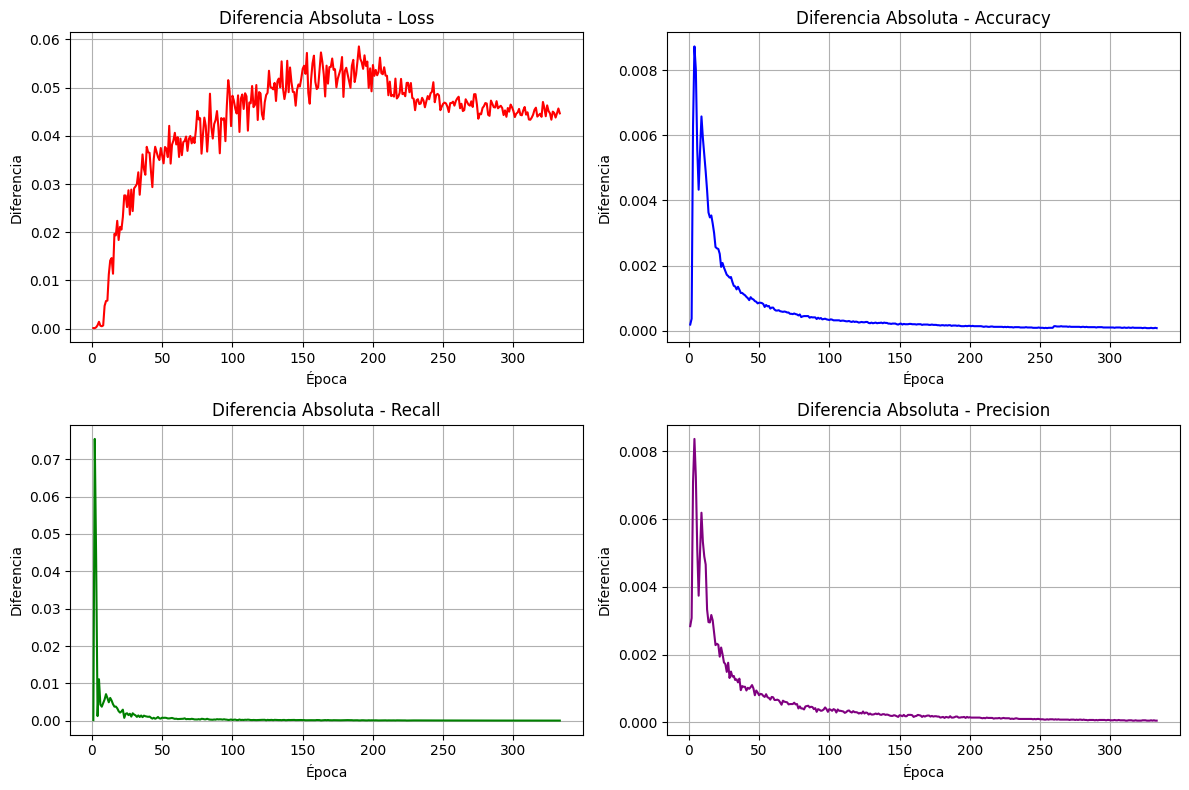

In [3]:
# cargamos los archivos
df_train = pd.read_csv("pesos_siamesa_final_19_enero/entrenamiento.txt")
df_valid = pd.read_csv("pesos_siamesa_final_19_enero/validacion.txt")

# Limpiamos nombres de columnas
df_train.columns = df_train.columns.str.strip()
df_valid.columns = df_valid.columns.str.strip()

# Eliminamos filas que no sean numéricas
df_train = df_train[pd.to_numeric(df_train["epoca"], errors="coerce").notnull()]
df_valid = df_valid[pd.to_numeric(df_valid["epoca"], errors="coerce").notnull()]

# Convertimos las columnas a tipo numérico
for col in ["epoca", "loss", "accuracy", "recall", "precision"]:
    df_train[col] = pd.to_numeric(df_train[col], errors="coerce")
    df_valid[col] = pd.to_numeric(df_valid[col], errors="coerce")

# Calculamos las diferencias absolutas
diff_df = pd.DataFrame({
    "epoca": df_train["epoca"],
    "loss": np.abs(df_valid["loss"] - df_train["loss"]),
    "accuracy": np.abs(df_valid["accuracy"] - df_train["accuracy"]),
    "recall": np.abs(df_valid["recall"] - df_train["recall"]),
    "precision": np.abs(df_valid["precision"] - df_train["precision"]),
})

# Graficamos la diferencia de los valores absolutos
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(diff_df["epoca"], diff_df["loss"], color='red')
plt.title("Diferencia Absoluta - Loss")
plt.xlabel("Época")
plt.ylabel("Diferencia")
plt.grid(True)

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(diff_df["epoca"], diff_df["accuracy"], color='blue')
plt.title("Diferencia Absoluta - Accuracy")
plt.xlabel("Época")
plt.ylabel("Diferencia")
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(diff_df["epoca"], diff_df["recall"], color='green')
plt.title("Diferencia Absoluta - Recall")
plt.xlabel("Época")
plt.ylabel("Diferencia")
plt.grid(True)

# Precision
plt.subplot(2, 2, 4)
plt.plot(diff_df["epoca"], diff_df["precision"], color='purple')
plt.title("Diferencia Absoluta - Precision")
plt.xlabel("Época")
plt.ylabel("Diferencia")
plt.grid(True)

plt.tight_layout()
plt.show()


#### Hallamos la época en la que se alcanza el menor loss en entrenamiento y validación.

In [4]:

min_loss_row = df_train.loc[df_train["loss"].idxmin()]
epoca_optima = int(min_loss_row["epoca"])

train_metrics = df_train[df_train["epoca"] == epoca_optima][["loss", "accuracy", "precision", "recall"]].iloc[0]

valid_metrics = df_valid[df_valid["epoca"] == epoca_optima][["loss", "accuracy", "precision", "recall"]].iloc[0]

# Imprimimos resultados
print(f"Época con menor loss en entrenamiento: {epoca_optima}")

print("\n--- Entrenamiento ---")
print(f"Loss     : {train_metrics['loss']:.6f}")
print(f"Accuracy : {train_metrics['accuracy']:.6f}")
print(f"Precision: {train_metrics['precision']:.6f}")
print(f"Recall   : {train_metrics['recall']:.6f}")

print("\n--- Validación ---")
print(f"Loss     : {valid_metrics['loss']:.6f}")
print(f"Accuracy : {valid_metrics['accuracy']:.6f}")
print(f"Precision: {valid_metrics['precision']:.6f}")
print(f"Recall   : {valid_metrics['recall']:.6f}")


Época con menor loss en entrenamiento: 243

--- Entrenamiento ---
Loss     : 0.190610
Accuracy : 0.883480
Precision: 0.863630
Recall   : 0.904550

--- Validación ---
Loss     : 0.241740
Accuracy : 0.883580
Precision: 0.863730
Recall   : 0.904620


In [5]:

df_train = pd.read_csv("pesos_siamesa_final_19_enero/entrenamiento.txt")
df_valid = pd.read_csv("pesos_siamesa_final_19_enero/validacion.txt")

df_train.columns = df_train.columns.str.strip()
df_valid.columns = df_valid.columns.str.strip()


cols = ["epoca", "loss", "accuracy", "recall", "precision", "lr"]
df_train[cols] = df_train[cols].apply(pd.to_numeric, errors='coerce')
df_valid[cols] = df_valid[cols].apply(pd.to_numeric, errors='coerce')


idx_min_val_loss = df_valid["loss"].idxmin()
epoca_min_val_loss = df_valid.loc[idx_min_val_loss, "epoca"]

valid_row = df_valid[df_valid["epoca"] == epoca_min_val_loss].iloc[0]
train_row = df_train[df_train["epoca"] == epoca_min_val_loss].iloc[0]

print(f" Época con menor loss en validación: {epoca_min_val_loss}\n")
print("Validación:")
print(f"  Loss:      {valid_row['loss']:.6f}")
print(f"  Accuracy:  {valid_row['accuracy']:.6f}")
print(f"  Precision: {valid_row['precision']:.6f}")
print(f"  Recall:    {valid_row['recall']:.6f}")

print("\nEntrenamiento:")
print(f"  Loss:      {train_row['loss']:.6f}")
print(f"  Accuracy:  {train_row['accuracy']:.6f}")
print(f"  Precision: {train_row['precision']:.6f}")
print(f"  Recall:    {train_row['recall']:.6f}")

 Época con menor loss en validación: 283

Validación:
  Loss:      0.238520
  Accuracy:  0.892350
  Precision: 0.870390
  Recall:    0.909520

Entrenamiento:
  Loss:      0.194360
  Accuracy:  0.892230
  Precision: 0.870320
  Recall:    0.909460


#### Hallamos la época en la que se obtiene el mayor accuracy en entrenamiento y validación.

In [6]:
df_train = pd.read_csv("pesos_siamesa_final_19_enero/entrenamiento.txt")
df_valid = pd.read_csv("pesos_siamesa_final_19_enero/validacion.txt")


df_train.columns = df_train.columns.str.strip()
df_valid.columns = df_valid.columns.str.strip()


cols = ["epoca", "loss", "accuracy", "recall", "precision", "lr"]
df_train[cols] = df_train[cols].apply(pd.to_numeric, errors='coerce')
df_valid[cols] = df_valid[cols].apply(pd.to_numeric, errors='coerce')

# Encontrar la época con el máximo accuracy en entrenamiento
idx_max_acc = df_train["accuracy"].idxmax()
epoca_max_acc = df_train.loc[idx_max_acc, "epoca"]

# Obtener métricas para esa época
train_row = df_train[df_train["epoca"] == epoca_max_acc].iloc[0]
valid_row = df_valid[df_valid["epoca"] == epoca_max_acc].iloc[0]

# Mostrar resultados
print(f" Época con mayor accuracy en entrenamiento: {epoca_max_acc}\n")
print("Entrenamiento:")
print(f"  Loss:      {train_row['loss']:.6f}")
print(f"  Accuracy:  {train_row['accuracy']:.6f}")
print(f"  Precision: {train_row['precision']:.6f}")
print(f"  Recall:    {train_row['recall']:.6}")

print("\nValidación:")
print(f"  Loss:      {valid_row['loss']:.6f}")
print(f"  Accuracy:  {valid_row['accuracy']:.6f}")
print(f"  Precision: {valid_row['precision']:.6f}")
print(f"  Recall:    {valid_row['recall']:.6f}")

 Época con mayor accuracy en entrenamiento: 333

Entrenamiento:
  Loss:      0.194280
  Accuracy:  0.901750
  Precision: 0.876340
  Recall:    0.91386

Validación:
  Loss:      0.238950
  Accuracy:  0.901830
  Precision: 0.876390
  Recall:    0.913900


In [7]:
df_train = pd.read_csv("pesos_siamesa_final_19_enero/entrenamiento.txt")
df_valid = pd.read_csv("pesos_siamesa_final_19_enero/validacion.txt")


df_train.columns = df_train.columns.str.strip()
df_valid.columns = df_valid.columns.str.strip()


cols = ["epoca", "loss", "accuracy", "recall", "precision", "lr"]
df_train[cols] = df_train[cols].apply(pd.to_numeric, errors='coerce')
df_valid[cols] = df_valid[cols].apply(pd.to_numeric, errors='coerce')

# Encontramos la época con el máximo accuracy en validación
idx_max_val_acc = df_valid["accuracy"].idxmax()
epoca_max_val_acc = df_valid.loc[idx_max_val_acc, "epoca"]

valid_row = df_valid[df_valid["epoca"] == epoca_max_val_acc].iloc[0]
train_row = df_train[df_train["epoca"] == epoca_max_val_acc].iloc[0]


print(f"Época con mayor accuracy en validación: {epoca_max_val_acc}\n")
print("Validación:")
print(f"  Loss:      {valid_row['loss']:.6f}")
print(f"  Accuracy:  {valid_row['accuracy']:.6f}")
print(f"  Precision: {valid_row['precision']:.6f}")
print(f"  Recall:    {valid_row['recall']:.6f}")

print("\nEntrenamiento:")
print(f"  Loss:      {train_row['loss']:.6f}")
print(f"  Accuracy:  {train_row['accuracy']:.6f}")
print(f"  Precision: {train_row['precision']:.6f}")
print(f"  Recall:    {train_row['recall']:.6f}")


Época con mayor accuracy en validación: 333

Validación:
  Loss:      0.238950
  Accuracy:  0.901830
  Precision: 0.876390
  Recall:    0.913900

Entrenamiento:
  Loss:      0.194280
  Accuracy:  0.901750
  Precision: 0.876340
  Recall:    0.913860
